In [ ]:
pip install pandas scikit-learn nltk

In [ ]:
!pip install ipywidgets

In [ ]:
pip install dataframe-image

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import string
import nltk
from nltk.stem import WordNetLemmatizer
from tqdm.auto import tqdm
import torch
from torch.utils.data import DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, log_loss, confusion_matrix, roc_curve, auc
import zipfile

In [ ]:
from google.colab import files
from google.colab import drive

In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def stratified_split(df):

    # Handle NaN values in 'LLM_model' where 'write_by' is 'Human'
    df['LLM_model'] = df.apply(lambda x: 'No_LLM' if pd.isna(x['LLM_model']) and x['write_by'] == 'Human' else x['LLM_model'], axis=1)

    # Define stratification criteria
    stratify_criteria = df[['write_by', 'language', 'domain', 'LLM_model']]

    # Split the dataset into training (70%), and a temporary set (30%)
    df_train, df_temp = train_test_split(df, test_size=0.30, stratify=stratify_criteria, random_state=42)

    # Split the temporary set into validation (10% of the original set) and test (20% of the original set)
    df_val, df_test = train_test_split(df_temp, test_size=2/3, stratify=stratify_criteria.loc[df_temp.index], random_state=42)

    # Return the dataframes
    return df_train, df_val, df_test


#---------------------------------------------------------------------

# Define paths
path_colab = '/content/drive/MyDrive/Colab Notebooks/3_Final_Dataset/'
path_notebook = 'C:/Users/amirm/Desktop/MONASH/Thesis/Working/Prepare/Code/3_Final_Dataset/'

# Toggle this to switch between Colab and local notebook paths
use_colab = False

# Set the base path based on the flag
base_path = path_colab if use_colab else path_notebook

#---------------------------------------------------------------------

# Helper function to read datasets
def load_dataset(file_name):
    return pd.read_csv(base_path + file_name)

#---------------------------------------------------------------------

df = load_dataset('Multi_Model_Multi_Lingual.csv')
df_train, df_val, df_test = stratified_split(df)


C:\Users\amirm\AppData\Local\Temp\ipykernel_2312\1374718463.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.95])


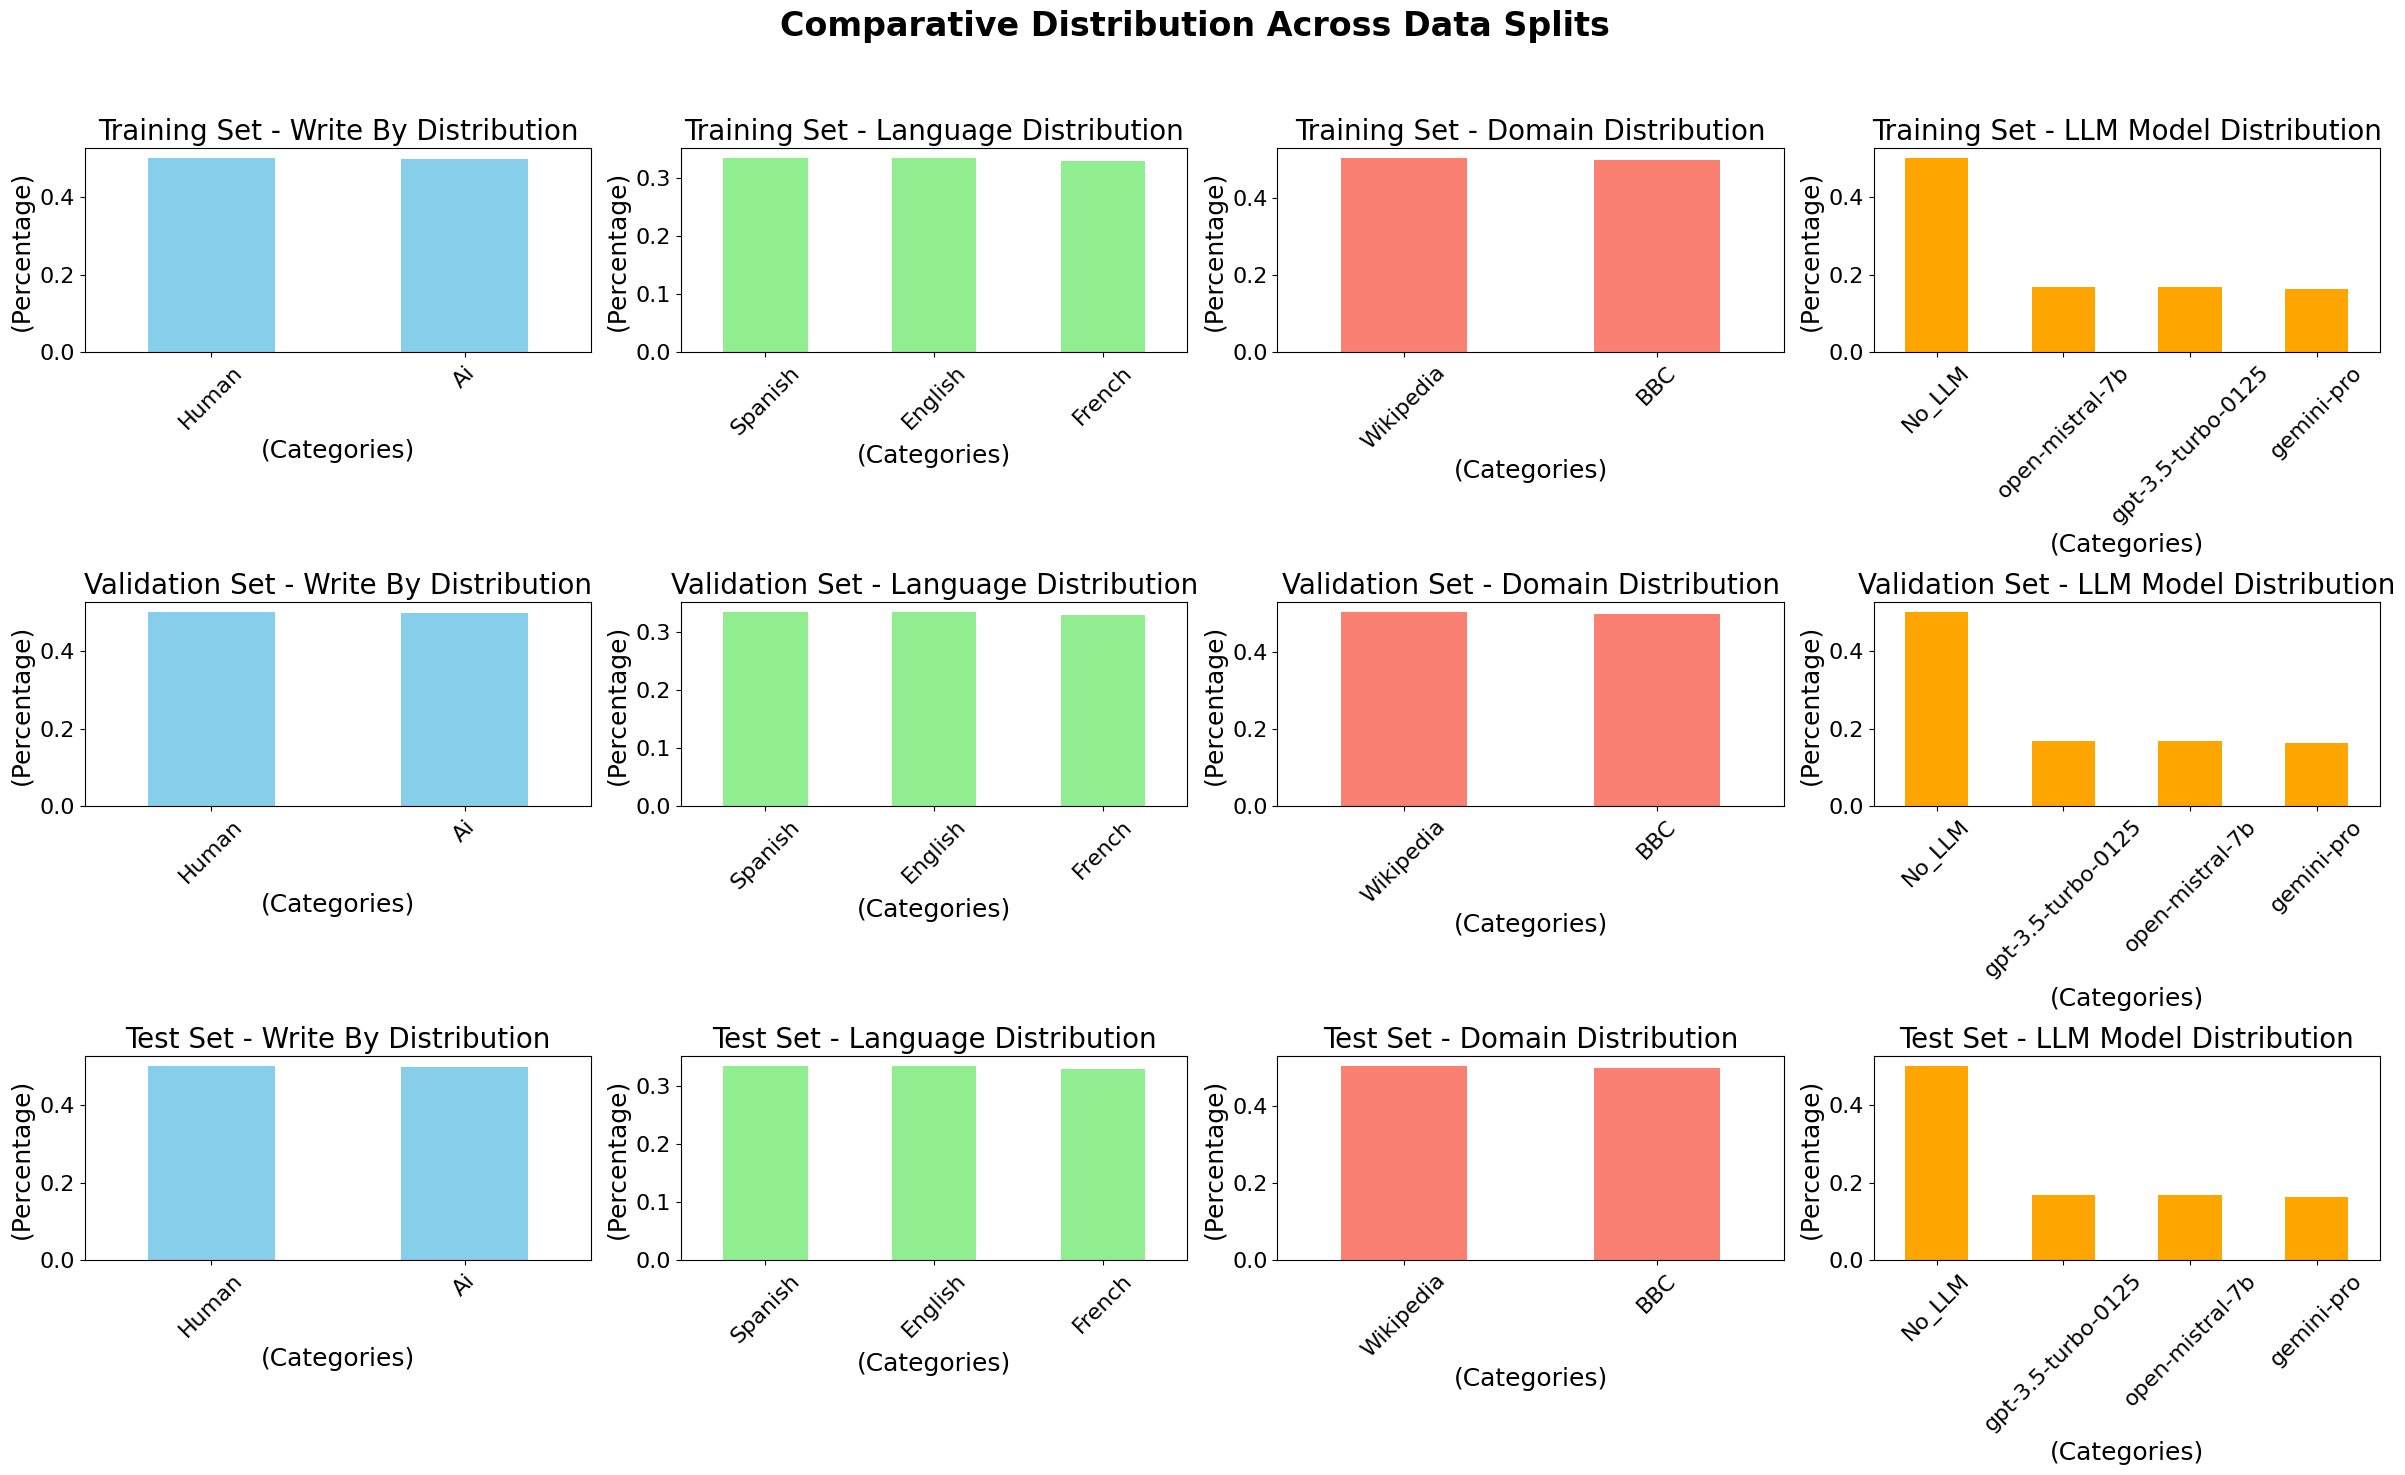

In [13]:
def check_distribution(dfs, titles):
    # Set up a large figure to hold subplots for each distribution
    fig, axes = plt.subplots(nrows=len(dfs), ncols=4, figsize=(24, len(dfs) * 5), constrained_layout=True)
    fig.suptitle('Comparative Distribution Across Data Splits', fontsize=24, weight='bold')

    # Labels for subplots
    labels = ['Write By Distribution', 'Language Distribution', 'Domain Distribution', 'LLM Model Distribution']
    colors = ['skyblue', 'lightgreen', 'salmon', 'orange']  # Colors for each subplot

    for i, df in enumerate(dfs):  # Iterate over each DataFrame and its corresponding title
        # Plot each type of distribution in a row
        df['write_by'].value_counts(normalize=True).plot(kind='bar', ax=axes[i, 0], color=colors[0], title=f'{titles[i]} - Write By')
        df['language'].value_counts(normalize=True).plot(kind='bar', ax=axes[i, 1], color=colors[1], title=f'{titles[i]} - Language')
        df['domain'].value_counts(normalize=True).plot(kind='bar', ax=axes[i, 2], color=colors[2], title=f'{titles[i]} - Domain')
        df['LLM_model'].value_counts(normalize=True).plot(kind='bar', ax=axes[i, 3], color=colors[3], title=f'{titles[i]} - LLM Model')

        # Setting labels for axes and rotating x-axis labels
        for j in range(4):
            axes[i, j].set_xlabel('(Categories)', fontsize=18)
            axes[i, j].set_ylabel('(Percentage)', fontsize=18)
            axes[i, j].set_title(f'{titles[i]} - {labels[j]}', fontsize=20)
            axes[i, j].tick_params(axis='x', labelsize=16, rotation=45)
            axes[i, j].tick_params(axis='y', labelsize=16)

    # Save the plot to a file
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig('multi_dataset_distributions_comparison.png', dpi=300)
    plt.show()

# Apply function to the datasets
check_distribution([df_train, df_val, df_test], ['Training Set', 'Validation Set', 'Test Set'])


In [ ]:
# Constants
MODEL_NAME = 'xlm-roberta-base'
MAX_LEN = 512
BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 2e-5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained(MODEL_NAME)

#---------------------------------------------------------------------

# Dataset Class
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

#---------------------------------------------------------------------

# Function to create data loaders
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = TextDataset(
        texts=df['text'].to_numpy(),
        labels=df['label'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(ds, batch_size=batch_size, num_workers=4)


In [22]:
# Function to train the model
def train_epoch(model, data_loader, optimizer, device, scheduler):
    model.train()
    total_loss = 0
    total_correct = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        total_correct += torch.sum(preds == labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    return total_correct.double() / len(data_loader.dataset), total_loss / len(data_loader.dataset)

#---------------------------------------------------------------------

# Function to evaluate the model with additional metrics
def eval_model(model, data_loader, device):
    model.eval()
    final_labels = []
    final_preds = []
    probabilities = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            probs = torch.nn.functional.softmax(logits, dim=-1)

            final_labels.extend(labels.cpu().detach().numpy())
            final_preds.extend(preds.cpu().detach().numpy())
            probabilities.extend(probs[:, 1].cpu().detach().numpy())

    acc = accuracy_score(final_labels, final_preds)
    prec = precision_score(final_labels, final_preds, average='binary')
    rec = recall_score(final_labels, final_preds, average='binary')
    f1 = f1_score(final_labels, final_preds, average='binary')
    conf_matrix = confusion_matrix(final_labels, final_preds)
    tp_rate = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
    fp_rate = conf_matrix[0, 1] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    roc_auc = roc_auc_score(final_labels, probabilities)
    cross_entropy = log_loss(final_labels, probabilities)

    return acc, prec, rec, f1, tp_rate, fp_rate, roc_auc, cross_entropy, final_labels, probabilities


In [25]:
def plot_roc_curve(final_labels, probabilities, filename="roc_curve.png"):
    # Calculate the ROC curve points
    fpr, tpr, thresholds = roc_curve(final_labels, probabilities)
    roc_auc = auc(fpr, tpr)  # Calculate the AUC of the ROC

    # Setting up the plot
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for Multi Model & Multi Lingual XLM_RoBERTa')
    plt.legend(loc="lower right")

    # Save the plot to a file
    plt.savefig(filename, format='png', bbox_inches='tight', dpi=300)
    plt.show()


In [ ]:
# Initialize results list
results = []

# Train and evaluate function
def train_and_evaluate(train_data, val_data, test_data, model_name):
    # Create data loaders
    train_loader = create_data_loader(train_data, tokenizer, MAX_LEN, BATCH_SIZE)
    val_loader = create_data_loader(val_data, tokenizer, MAX_LEN, BATCH_SIZE)
    test_loader = create_data_loader(test_data, tokenizer, MAX_LEN, BATCH_SIZE)

    # Initialize model
    model = XLMRobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(DEVICE)
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    total_steps = len(train_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    best_val_f1 = 0.0  # Initialize the best F1 score

    # Train model
    for epoch in range(EPOCHS):
        train_acc, train_loss = train_epoch(model, train_loader, optimizer, DEVICE, scheduler)
        print(f'Epoch {epoch + 1}/{EPOCHS}, Train Loss: {train_loss}, Accuracy: {train_acc}')

        # Evaluate on validation set
        val_metrics = eval_model(model, val_loader, DEVICE)
        print(f'Validation Metrics - Accuracy: {val_metrics[0]}, Precision: {val_metrics[1]}, Recall: {val_metrics[2]}, F1 Score: {val_metrics[3]}')

        # Check if the current model's F1 score on the validation set is the best one so far
        if val_metrics[3] > best_val_f1:
            best_val_f1 = val_metrics[3]
            torch.save(model.state_dict(), f"{model_name}.bin")
            print(f"Saved new best model with F1 score: {best_val_f1}")

    # After training all epochs, load the best model for evaluation
    model.load_state_dict(torch.load(f"{model_name}.bin"))

    # Evaluate on test set
    test_metrics = eval_model(model, test_loader, DEVICE)
    results.append([model_name, 'Internal Test'] + list(test_metrics[:-2]))

    # Plot ROC curve for test set
    plot_roc_curve(test_metrics[-2], test_metrics[-1], "roc_multi_model_multi_lingual_XLM_RoBERTa.png")


model_name = "Multi_Model_Multi_Lingual_XLM_RoBERTa"
train_and_evaluate(df_train, df_val, df_test, model_name)

In [35]:
# Before creating DataFrame, round the metrics in the results list and filter out unwanted metrics
results_for_csv = []
for result in results:
    filtered_result = [result[0], result[1], round(result[2], 3), round(result[5], 3), round(result[8], 3)]  # Include only Model, Test Type, Accuracy, F1 Score, ROC AUC
    results_for_csv.append(filtered_result)

# Create DataFrame from filtered results with rounded numbers
results_df = pd.DataFrame(results_for_csv, columns=['Model', 'Test Type', 'Accuracy', 'F1 Score', 'AUROC'])

# Save the results to a CSV file
results_csv_path = '/content/drive/MyDrive/Colab Notebooks/multi_model_multi_lingual_evaluation_results.csv'
results_df.to_csv(results_csv_path, index=False)


In [4]:
results_df = pd.read_csv('multi_model_multi_lingual_evaluation_results.csv')

In [5]:
results_df

,Model,Test Type,Accuracy,F1 Score,AUROC
0,Multi_Model_Multi_Lingual_XLM_RoBERTa,Internal Test,0.907,0.9,0.993


In [6]:
def modify_model_name(model_name):
    parts = model_name.split('_')
    new_name = ' '.join(parts)
    return new_name

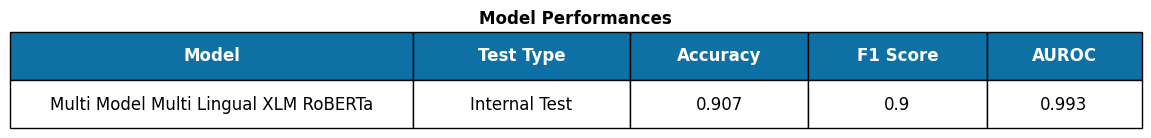

In [7]:
def render_mpl_table(data, row_height=0.625, font_size=12,
                     header_color='#0e70a5', row_colors=['#f1f1f2', 'w'], edge_color='black',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    data['Model'] = data['Model'].apply(modify_model_name)

    # Calculate the maximum string length for each column and apply padding
    padding = 15  # Define padding size
    col_widths = [max(data[col].apply(lambda x: len(str(x))).max(), len(col)) + padding for col in data.columns]
    col_widths = [x * 0.1 for x in col_widths]  # Scale factor for width

    if ax is None:
        size = (np.array([sum(col_widths), data.shape[0]+1]) * np.array([1, row_height]))
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns,
                         colWidths=col_widths, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)  # Set border color for visibility
        cell.set_text_props(ha='center')  # Align all cell values to the center
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0] % len(row_colors)])

    return ax

# Ensure you have the results_df DataFrame correctly defined with appropriate data.
render_mpl_table(results_df, header_columns=0)
plt.title('Model Performances', fontsize=12, weight='bold')
plt.savefig('multi_lingual_multi_model_evaluation_table.png', bbox_inches='tight', dpi=300)
plt.show()


In [ ]:
# To download the models as zip file
def zip_files(directory, output_zip):
    # Create a ZipFile object
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Walk through the directory
        for root, dirs, files in os.walk(directory):
            for file in files:
                # Create complete filepath of file in directory
                filepath = os.path.join(root, file)
                # Add file to zip
                zipf.write(filepath, arcname=os.path.relpath(filepath, directory))

# Specify the directory to zip
directory_to_zip = '/content'
output_zip_file = 'content_directory.zip'

# Call the function
zip_files(directory_to_zip, output_zip_file)

# Provide a link to download the zip
files.download(output_zip_file)
